# Challenge
An investor retires at age $Y$ and withdraws $X$ from their account each year. Initially, the investor's account contains $\$1$ million. At the beginning of each year, the investor reallocates their funds so that 60\% is invested in stocks and 40\% is invested in bonds. The investor lives for a random number of years, which is uniformly distributed on the closed interval $[70-Y, 90-Y]$, where $50 \leq Y \leq 65$. The probability of depleting the account is $p$. 

Write a function that takes $X$ and $Y$ as inputs and returns probability $p$. It runs a Monte Carlo simulation that has a stock fund ($\mu = 6\%$, $\sigma = 20\%$) and a bond fund ($\mu= 3\%$, $\sigma = 3\%$) that both follow geometric Brownian motion. Suppose the stock and bond return correlation is $\rho = 0.2$. Use Python and any needed packages to fit a machine learning algorithm that will predict $p$ given $X$ and $Y$. 

# Summary
We created a function that used Monte Carlo simulations to predict the probability that an investor runs out of money before the end of his or her life, given that the investor removes $X$ at the end of each year and is currently age $Y$. This function was sucessfully vectorized. However, it still ran quite slowly, so we only used $N = 400$ simulations for each probability calculation. The result was a noisy signal.

Once we ran the Monte Carlo simulations, we fit the results to machine learning models and accessed the goodness of fit. We transformed the data to log-odds because the codomain of $(-\infty, \infty)$ is easier for most regression algorithm to predict than the codomain of $[0, 1]$. We considered the following models:
* An OLS regression with a bias term and explanatory variables $X$ and $Y$.
* An OLS regression with a bias term and explanatory variables $X$, $Y$, $X^2$, $XY$, and $Y^2$.
* An XGBoost regression with explanatory variables $X$, $Y$, $X^2$, $XY$, and $Y^2$.
* A neural network regression with explanatory variables $X$, $Y$, $X^2$, $XY$, and $Y^2$.

Though XGBoost tended to over-fit the data, results were strong enough that we chose it as our preferred model. When we fit the model with the training and validation sets, grid search selected much more conservative hyperparameters for the XGBoost model than when it simply used the training data. The mean square errors out-of-sample were even smaller than on the validation set.


# Packages

In [6]:
import numpy as np
import scipy.stats as stats
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import os

# Use LaTeX in graphs
plt.rcParams.update({"text.usetex": True})

# Set the local directory 
os.chdir(r'/Users/charlesrambo/Desktop/GitHub data')

# Generating the data
An investor of age $Y$ removes $X$ from his or her fund at the end of each year. The initial fund value is $F_0 = \$1,000,000$. Each year $n$, returns 
$$
\displaystyle R_{n} \sim{\mathcal{N}\left(\left[\begin{array}{c} 0.06\\ 0.03\end{array}\right], \left[\begin{array}{c c} 0.20^2 & 0.2(0.20)(0.03)\\ 0.2(0.20)(0.03) & 0.03^2\end{array}\right]\right)}.
$$
The first coordinate corresponds to the stock return and the second corresponds to the bond return. The weight invested in each asset at the beginning of the year is 
$$
w = \left[\begin{array}{c} 0.6\\ 0.4\end{array}\right].
$$
This implies that the return of the fund in year $n$ is
$$
w^T\cdot exp(R_{n}) - 1
$$
whenever the concept makes sense.

The investor lives $T\sim{\mathcal{U}[70 - Y, 90 - Y]}$ more years. The value of $T$, almost surely, is not an integer because the set of integers has measure 0--as a result the cases where $T$ is an integer do not need to be considered except for theoretical purposes. Suppose $T \in [n, n + 1)$. Assuming we can take short positions, the total amount within the fund at time $T$ is
$$
F_T = F_n w'\cdot exp\Big(R_{n + 1}(T - n)\Big) = \left(F_{n - 1}w'\cdot exp(R_{n})- X\right)w'\cdot exp\Big(R_{n + 1}(T - n)\Big).
$$
Furthermore, notice that $F_{m - 1} \leq 0$ implies
$$
F_m = F_{m - 1}w^T\cdot exp(R_{m}) - X< 0\qquad\text{and}\qquad F_{m + u} = F_m w^T\cdot exp(R_{m + 1}u) < 0
$$
for $0 < u < 1$. As a result, to determine whether the fund ran out of money at some time in the interval $[0, T]$, we only need to see whether $F_T < 0$. This observation will allow us to vectorize our code. 

We used Monte Carlo simulations to estimate the probability that the fund runs out of money. We simulated $N = 400$ Monte Carlo simulations for each probability, though we considered the three antithetic cases of $R_n$. However, despite sucessful vectorization and the use of antithetic cases, it takes approximately three hours to generate 20,000 observations on our 8GB of RAM MacBook Air. If we had more computational power, it is clear that we could improve our results by considering a larger value of $N$.


In [7]:
# Number of Monte Carlo simulations used to calculate each probability
N = 400

# Create probability function
def calc_prob(X, Y):
   
    # Amount in the fund initially
    initial_val = 10**6 
    
    # Weights in stocks and bonds, respectively
    wt = np.array([0.60, 0.40])
    
    # Expected return (mu) and standard deviation (sigma) of stocks and bonds
    mu = np.array([0.06, 0.03])
    sigma = np.array([0.20, 0.03])

    # Correlation between stocks and bonds
    rho = 0.2
    
    # Simulates whether ran out of money; returns value btw 0 and 1
    def run_sim(X, Y):

        # Generate years
        life_left = stats.uniform.rvs(loc = 70 - Y, scale = 20)
        
        # Numer of rows in arrays
        rows = int(life_left + 1)
        
        # Calculate fraction of year in the last year of life
        last_year = life_left - rows + 1
        
        # Factor by which the fund grows in given year
        def calc_scalar(stock_rtn, bond_rtn, dur):
        
            return wt[0] * np.exp(stock_rtn * dur) + wt[1] * np.exp(bond_rtn * dur)
        
        # Vectorize calc_scalar
        calc_scalar = np.vectorize(calc_scalar)
        
        def prep_rets(rets, rows):

            # Stocks and bonds have correlation rho
            rets[:, 1] = rho * rets[:, 0] + np.sqrt(1 - rho**2) *  rets[:, 1]
        
            # Shift and scale so results have correct mean and sd
            rets[:, [0, 1]] = mu + rets[:, [0, 1]] @ np.diag(sigma)
        
            # Obtain scalar by which fund grows
            rets[:, 2] =  calc_scalar(rets[:, 0], rets[:, 1], 1)
        
            # Calculation for last year is different
            rets[0, 2] =  calc_scalar(rets[0, 0], rets[0, 1], last_year)
            
            return rets
             
        # Generate normals
        rets_0 = stats.norm.rvs(size = (rows, 3))
        
        # Antithetic normals
        rets_1 = rets_0
        rets_1[: , 0] = -rets_1[: , 0]
        
        rets_2 = rets_0
        rets_2[:, 1] = -rets_2[: , 1]
        
        rets_3 = -rets_0
        
        # Convert standard normals to normals of given distributions
        rets_0, rets_1 = prep_rets(rets_0, rows), prep_rets(rets_1, rows)
        rets_2, rets_3 = prep_rets(rets_2, rows), prep_rets(rets_3, rows)
        
        # Calculate cash flows
        cash_flows = np.zeros(shape = (rows, 1))
        
        # First cash flow is positive 1 million
        cash_flows[0, 0] = initial_val
        
        # Other cash flows are negative X
        cash_flows[1:, 0] = -X
        
        # Function returns 1 if ran out of money and 0 otherwise
        get_bool = lambda rets: int((np.flip(cash_flows).T @ np.cumprod(rets[:, 2]))[0] < 0)
        
        # Calculate final value given the four cases
        final_val = np.mean([get_bool(rets) for rets in [rets_0, rets_1, rets_2, rets_3]])
        
        return final_val
    
    # Vectorize simulation   
    run_sim = np.vectorize(run_sim)
       
    # Calculate fraction of times where ran out in N simulations
    return np.mean(run_sim(np.repeat(X, N), np.repeat(Y, N)))

print('We estimate the probability that we run out of money given X = 50,000 and Y = 55 is {}.'.format(
    round(calc_prob(50000, 55), 2)))

We estimate the probability that we run out of money given X = 50,000 and Y = 55 is 0.03.


Ten thousand of the observations were used for the training and testing sets, i.e. we generated 20,000 observations in total. We supposed
$$
X \in \left[30000, 150000\right]\qquad\text{and}\qquad Y \in \left[50, 65\right].
$$
For the training set, these observations were spaced evenly throughout the respective domains of $X$ and $Y$.
For the testing set, we randomly generated $X$- and $Y$-values using a uniform distribution over the respective domains of $X$ and $Y$. The testing set was broken into two sets of size 5,000. One set was used for model validation, and the other was used to access the efficacy of our selected model out-of-sample. 

The code to generate our 20,000 observations takes approximately three hours to run when $N = 400$. As a result, we saved the generated data to a CSV file. Run the block of code below at your own risk.

In [ ]:
# Vectorize function
calc_prob = np.vectorize(calc_prob)

# Specify number of trails
trails = 10**4

# Create function to generate data
def gen_data(trails, uni_par = True):
    
    # Calculate number of unique X- and Y-values
    n = int(np.sqrt(trails) + 0.5)
    
    # Initialize array
    data = np.zeros((n**2, 3))
    
    if uni_par == True:
        # Create evenly spaced observations
        X_vals = np.linspace(3 * 10**4, 1.5 * 10**5, num = n)
        Y_vals = np.linspace(50, 65, num = n)
        
    else: 
        # Create random observations
        X_vals = stats.uniform.rvs(loc = 3 * 10**4, scale = 1.5 * 10**5 - 3 * 10**4, size = n)
        Y_vals = stats.uniform.rvs(loc = 50, scale = 65 - 50, size = n)
  
    # Calculate Cartesian product
    data[:, [0, 1]] = [(x, y) for x in X_vals for y in Y_vals]
    
    # Use cal_prob function to estimate probabilities
    data[:, 2] = calc_prob(data[:, 0], data[:, 1])
    
    return data

# Start timer
start_time = time.time()  
 
train = pd.DataFrame(gen_data(trails, uni_par = True), columns = ['X', 'Y', 'p'])
print('We are half way done! It has been {} minutes so far.'.format(round((time.time() - start_time)/60, 2)))
test = pd.DataFrame(gen_data(trails, uni_par = False), columns = ['X', 'Y', 'p'])

# End timer
duration = (time.time() - start_time)/60
print('The process took {} minutes in total.'.format(round(duration, 2)))

# Save results so we don't have to do this many times
writer = pd.ExcelWriter('sims_' + str(N) + '.xlsx', engine = 'xlsxwriter')
train.to_excel(writer, sheet_name = 'train', index = False) 
test.to_excel(writer, sheet_name = 'test', index = False) 
writer.save()

# Processing the data and exploratory analysis
As mentioned previously, we saved the data so that we would not have to rerun the Monte Carlo simulations. The data frame temp will be separated into a validation set and an out-of-sample set later in this section.


In [8]:
# Create data frame with training data
train = pd.read_excel(r'sims_400.xlsx', sheet_name = 'train')

# Temporarily create data frame of validation and out-of-sample data
temp = pd.read_excel(r'sims_400.xlsx', sheet_name = 'test')

train.head()

X          Y         p
0  30000.0  50.000000  0.004375
1  30000.0  50.151515  0.003750
2  30000.0  50.303030  0.004375
3  30000.0  50.454545  0.002500
4  30000.0  50.606061  0.003750

Because we are dealing with a probability, the codomain of the map from $(X, Y) \mapsto p$ is the closed interval $[0, 1]$. This is problematic for many regression techniques. We would prefer the codomain to be $(-\infty, \infty)$. As a result, we will apply a transformation to $p$. We postulate that
$$
p = \frac{1}{1 + \exp\Big(-f(X,\ Y) - \epsilon_{X, Y}\Big)}
$$
for some function $f$. This implies
$$
f(X,\ Y) = logit(p) + \epsilon_{X, Y} = \log\left(\frac{p}{1 - p}\right) + \epsilon_{X, Y}.
$$
Hence, we will map $p$ to the corresponding log-odds and then use regression techniques to estimate $f$.

Because each probability calculation only used $N = 400$ simulations, we have some observations with probability 0 and 1. This creates a problem for our log-odds calculation since these values map onto log-odds of $-\infty$ and $\infty$, respectively. We will suppose that if we had doubled the number of simulations, we would have obtained one observation inconsistent with the others, i.e. we will map
$$
0 \mapsto \frac{1}{2N}\qquad\text{and}\qquad 1 \mapsto \frac{2N - 1}{2N}.
$$


In [9]:
# Assume that if we doubled N we would get one result inconsistent with the others
error = 0.5/N

# Convert values of p = 0 or 1 into values in the open interval (0, 1)
def make_indef(p, error):
    
    if p == 1:
        
        return p - error
    
    elif p == 0:
        
        return error
    
    else:
        
        return p

# Create function to calculate log-odds
def log_odds(p):
    
    p = make_indef(p, error)
    
    return np.log(p/(1 - p))

# Create function to convert log-odds to a probability
def prob(log_odds):
    
    return np.exp(log_odds)/(1 + np.exp(log_odds))

# Vectorize inverse function for later
prob = np.vectorize(prob)

# Calculate the log-odds
train['log_odds'] = train['p'].apply(log_odds)
temp['log_odds'] = temp['p'].apply(log_odds)

train.describe()

X             Y             p      log_odds
count   10000.000000  10000.000000  10000.000000  10000.000000
mean    90000.000000     57.500000      0.516667     -0.011236
std     34990.925405      4.373866      0.404473      3.537284
min     30000.000000     50.000000      0.000000     -7.377134
25%     60000.000000     53.750000      0.046250     -3.026340
50%     90000.000000     57.500000      0.606875      0.434195
75%    120000.000000     61.250000      0.950625      2.957675
max    150000.000000     65.000000      1.000000      7.377134

Since we rework models that perform poorly on our validation set, we will break the "test" observations into a validation set and an out-of-sample set. The training data will be used to find a good model specification, hyperparameter selection, and parameter selection. The mean square errors on our validation set will be used to pick the best model after we have fitted them to our training set. The last step will be to run our model on the out-of-sample data to see how well the model would perform on completely unseen data. The variables indep_val, indep_out, dep_val, dep_out stand for independent variables validation set, independent variables out-of-sample set, dependent variables validation set, and dependent variables out-of-sample set, respectively.

In [10]:
# Create independent and dependent validation and out-of-sample sets
indep_val, indep_out, dep_val, dep_out = train_test_split(temp[['X', 'Y']], temp[['p', 'log_odds']], test_size = 0.5, 
                                                          random_state = 0)

# Delete data frame which has done its job
del temp

We will begin our model selection by graphing the data. As can be seen, for a fixed $Y = y$, the graph of
$$
p = \frac{1}{1 +\exp(-f(X,\ Y = y) - \epsilon_{X, y})}
$$
looks similar to a logistic curve and 
$$
logit(p) = f(X,\ Y = y) + \epsilon_{X, y}
$$
looks somewhat like linear increasing linear function. This indicates that our choice of transformation was reasonable.

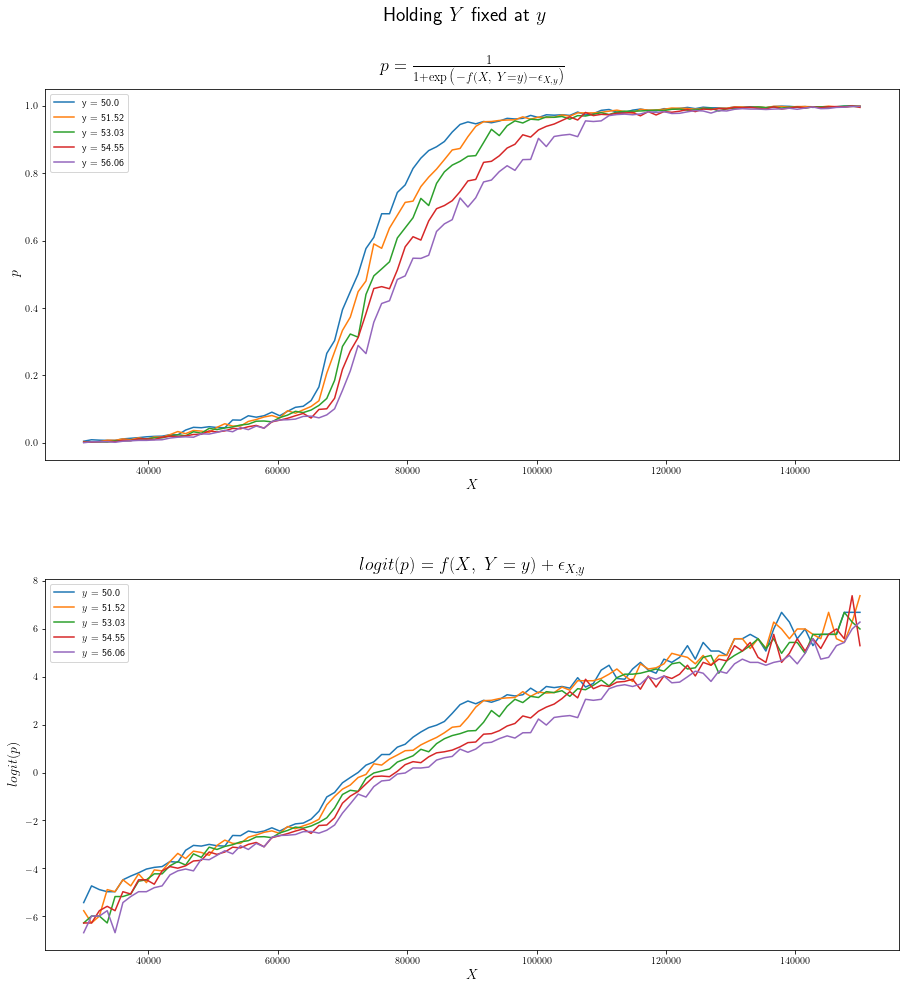

In [11]:
# Pick values of X and Y for countours
Y_vals = np.unique(train['Y'])[0:50:10]
X_vals = np.unique(train['X'])[0:20:4]

fig, ax = plt.subplots(2, 1, figsize = (15,15))

fig.suptitle(r'Holding $Y$ fixed at $y$', fontsize = 20)
plt.tight_layout(pad = 10)

for Y in Y_vals:
    ax[0].set_title(r'$p = \frac{1}{1 + \exp\Big(-f(X,\ Y = y) - \epsilon_{X, y}\Big)}$', fontsize = 18)
    ax[0].plot(train.loc[train['Y'] == Y, 'X'], train.loc[train['Y'] == Y, 'p'], label = 'y = {}'.format(round(Y, 2)))
    ax[0].set_xlabel(r'$X$', fontsize = 14) 
    ax[0].set_ylabel(r'$p$', fontsize = 14) 
    ax[0].legend()
    
    ax[1].set_title(r'$logit(p) = f(X,\ Y = y) + \epsilon_{X, y}$', fontsize = 18)
    ax[1].plot(train.loc[train['Y'] == Y, 'X'], train.loc[train['Y'] == Y, 'log_odds'], label = r'$y$ = {}'.format(round(Y, 2)))
    ax[1].set_xlabel(r'$X$', fontsize = 14) 
    ax[1].set_ylabel(r'$logit(p)$', fontsize = 14) 
    ax[1].legend() 


In the next contour graphs we will will fix $X = x$ and consider the graphs of
$$
p = \frac{1}{1 +\exp(-f(X = x,\ Y) - \epsilon_{x, Y})}
$$
and
$$
logit(p) = f(X = x,\ Y) + \epsilon_{x, Y}.
$$
These graphs both appear to be decreasing linear functions.

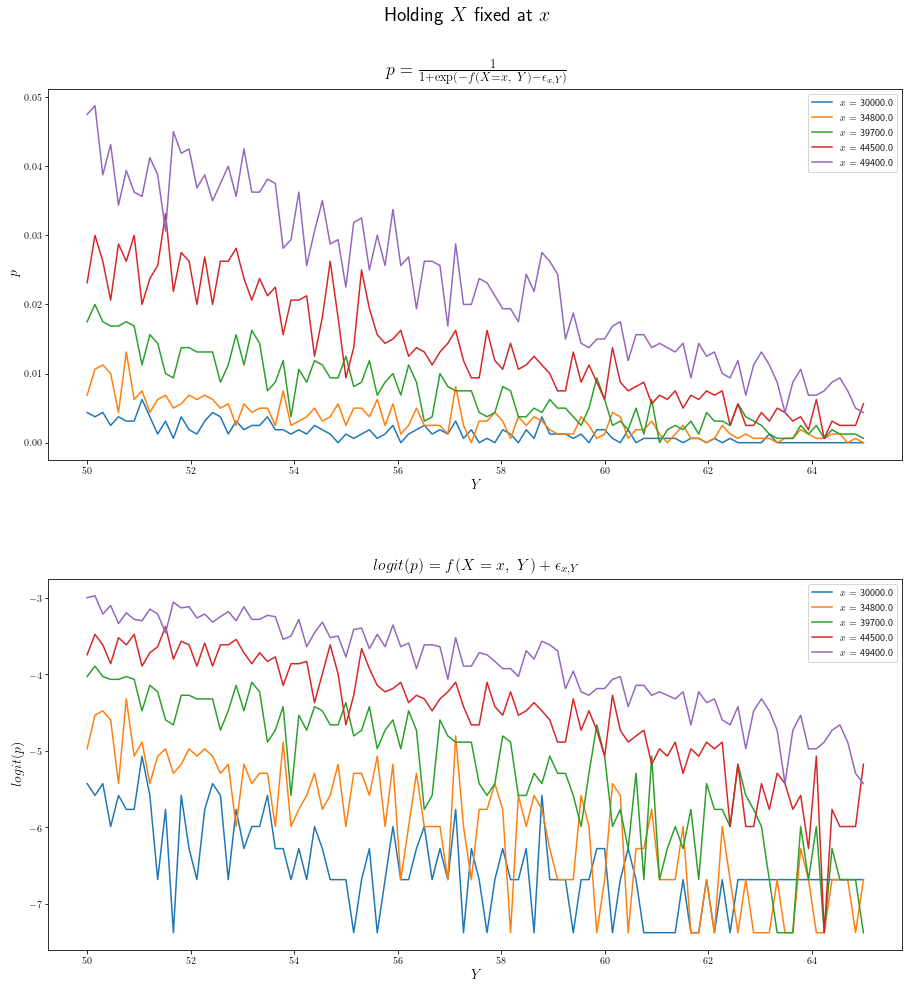

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (15, 15))
fig.suptitle(r'Holding $X$ fixed at $x$', fontsize = 20)
plt.tight_layout(pad = 10)

for X in X_vals:
    ax[0].set_title(r'$p = \frac{1}{1 + \exp(-f(X = x,\ Y) - \epsilon_{x, Y})}$', fontsize = 18)
    ax[0].plot(train.loc[train['X'] == X, 'Y'], train.loc[train['X'] == X, 'p'], label = r'$x$ = {}'.format(round(X, -2)))
    ax[0].set_xlabel(r'$Y$', fontsize = 14) 
    ax[0].set_ylabel(r'$p$', fontsize = 14) 
    ax[0].legend()
    
    ax[1].set_title(r'$logit(p) = f(X = x,\ Y) + \epsilon_{x, Y}$', fontsize = 16)
    ax[1].plot(train.loc[train['X'] == X, 'Y'], train.loc[train['X'] == X, 'log_odds'], label = r'$x$ = {}'.format(round(X, -2)))
    ax[1].set_xlabel(r'$Y$', fontsize = 14) 
    ax[1].set_ylabel(r'$logit(p)$', fontsize = 14) 
    ax[1].legend()

plt.show()

We will introduce the second-order variables $X^2$, $XY$, and $Y^2$. These variables may help our models capture the convexity within the graphs above. More justification for the inclusion of $X^2$, $XY$, and $Y^2$ will be given later.

Since one of the models we will consider is a neural network, we will standardize the variables now. We apply the standardization obtained from the training set to the validation and out-of-sample sets to reduce data leakage. Coincidently, this will not end up being a necessary step because we will not select the neural network as our preferred model.

In [13]:
# Add quadratic terms to explain convexity
def create_vars(data):
    
    indep = data[['X', 'Y']]
    indep['X^2'] = data['X']**2
    indep['XY'] = data['X'] * data['Y']
    indep['Y^2'] = data['Y']**2
    
    return indep
    
# Create numpy array of independent variables
indep_train = create_vars(train)

# Standard scalar method and fit to independent variables; needed for neural net
scaler = StandardScaler().fit(indep_train)

# Apply standard scalar to variables
indep_train = scaler.transform(indep_train)

# Create numpy array of dependent variables
dep_train = train[['p', 'log_odds']]

# Apply same scaling to validation and out-of-sample set; same to avoid info leakage
indep_val = scaler.transform(create_vars(indep_val))
indep_out = scaler.transform(create_vars(indep_out))


/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Model selection 
To assess the efficacy of our models, we will calculate the mean square errors
$$
\displaystyle \frac{1}{5000}\sum_{i = 0}^{4999} \left(logit(p_i) - logit(\hat{p}_i)\right)^2\qquad\text{and}\qquad \frac{1}{5000}\sum_{i = 0}^{4999} \left(p_i - \hat{p}_i\right)^2.
$$
The log-odds sum of square errors is what is minimized within the fitting process of our algorithms. This means that the tails, in particular, will strongly affect parameter selection. We will also consider the alternative metric for two reasons:
1. The tails of our observed probabilities and log-odds are not particularly accurate because we only ran N = 400 Monte Carlo simulations per probability calculation.
2. An alternative metric somewhat reduces the risk of over-fitting. Since the parameters were not optimized to reduce the error of this alternative metric, good model specification is more important.

Within this analysis, the two results turned out to be largely consistent.

In [14]:
# Create function to judge effectiveness of model in validation set
def penalty(dep_true, dep_pred):
    
    return np.mean((dep_true['p'] - prob(dep_pred))**2), np.mean((dep_true['log_odds'] - dep_pred)**2)

# Create pandas data frame to record MSE on validation set and out-of-sample MSE on our preferred model
results = pd.DataFrame(columns = ['MSE_p', 'MSE_log_odds'], index = ['Simple_OLS', 'Complex_OLS', 'XGB', 
                                                                     'Neural_Net', 'XGB_out'])
# Save array of default colors
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Create function which graphs contours
def show_fixed_Y_contours(dep_pred, model):
  
    # Save predicted values
    train['pred'] = dep_pred
    
    # Choose X- and Y-values for contours
    X_vals = np.unique(train['X'])[0:20:4]
    Y_vals = np.unique(train['Y'])[0:50:10]
    
    # Initialize i to 0
    i = 0

    fig, ax = plt.subplots(2, 1, figsize = (15, 25))
    fig.suptitle(r'Holding $Y$ fixed at $y$', fontsize = 20)
    plt.tight_layout(pad = 10)

    for Y in Y_vals:
        ax[0].set_title(r'$p = \frac{1}{1 + \exp(-f(X,\ Y = y) - \epsilon_{X, y})}$', fontsize = 18)
        ax[0].plot(train.loc[train['Y'] == Y, 'X'], train.loc[train['Y'] == Y, 'p'], color = colors[i], label = r'$y$ = {}'.format(round(Y, 2)))
        ax[0].plot(train.loc[train['Y'] == Y, 'X'], train.loc[train['Y'] == Y, 'pred'].apply(prob), color = colors[i], linestyle='dashed', 
                   label = r'{} with $y$ = {}'.format(model, round(Y, 2)))
        ax[0].set_xlabel(r'$X$', fontsize = 16) 
        ax[0].set_ylabel(r'$p$', fontsize = 16) 
        ax[0].legend()
    
        ax[1].set_title(r'$logit(p) = f(X,\ Y = y) + \epsilon_{x, Y}$', fontsize = 16)
        ax[1].plot(train.loc[train['Y'] == Y, 'X'], train.loc[train['Y'] == Y, 'log_odds'], color = colors[i], label = r'$y$ = {}'.format(round(Y, 2)))
        ax[1].plot(train.loc[train['Y'] == Y, 'X'], train.loc[train['Y'] == Y, 'pred'], color = colors[i], linestyle = 'dashed', 
                   label = r'{} with $y$ = {}'.format(model, round(Y, 2)))
        ax[1].set_xlabel(r'$X$', fontsize = 16) 
        ax[1].set_ylabel(r'$logit(p)$', fontsize = 16) 
        ax[1].legend()
        i += 1
    
    plt.show()
    
def show_fixed_X_contours(dep_pred, model):
  
    # Save predicted values
    train['pred'] = dep_pred
    
    # Choose X- and Y-values for contours
    X_vals = np.unique(train['X'])[0:20:4]
    Y_vals = np.unique(train['Y'])[0:50:10]
    
    # Initialize i to 0
    i = 0

    fig, ax = plt.subplots(2, 1, figsize = (15, 25))
    fig.suptitle(r'Holding $X$ fixed at $x$', fontsize = 20)
    plt.tight_layout(pad = 10)
    
    for X in X_vals:
        ax[0].set_title(r'$p = \frac{1}{1 + \exp(-f(X = x,\ Y) - \epsilon_{x, Y})}$', fontsize = 18)
        ax[0].plot(train.loc[train['X'] == X, 'Y'], train.loc[train['X'] == X, 'p'], color = colors[i], label = r'$x$ = {}'.format(round(X, -2)))
        ax[0].plot(train.loc[train['X'] == X, 'Y'], train.loc[train['X'] == X, 'pred'].apply(prob), color = colors[i], linestyle = 'dashed', 
                   label = r'{} with $x$ = {}'.format(model, round(X, -2)))
        ax[0].set_xlabel(r'$Y$', fontsize = 16) 
        ax[0].set_ylabel(r'$p$', fontsize = 16) 
        ax[0].legend()
    
        ax[1].set_title(r'$logit(p) = f(X = x,\ Y) + \epsilon_{x, Y}$', fontsize = 18)
        ax[1].plot(train.loc[train['X'] == X, 'Y'], train.loc[train['X'] == X, 'log_odds'], color = colors[i], 
                   label = r'$x$ = {}'.format(round(X, -2)))
        ax[1].plot(train.loc[train['X'] == X, 'Y'], train.loc[train['X'] == X, 'pred'], color = colors[i], linestyle = 'dashed', 
                   label = r'{} with $x$ = {}'.format(model, round(X, -2)))
        ax[1].set_xlabel(r'$Y$', fontsize = 16) 
        ax[1].set_ylabel(r'$logit(p)$', fontsize = 16) 
        ax[1].legend()   
        i += 1

    plt.show()


## OLS models
As a result of our graphs, our first attempt will be an estimation of $f$ via
$$
\hat{f}(X,\ Y) = a_0 + a_1X + a_2Y + e_{X, Y}.
$$
This model produced relatively weak results. 

Close inspection of the graphs above shows some concavity. To capture this, we will introduce second-order terms into our regression. In particular, we estimate $f$ using the function
$$
\hat{f}(X,\ Y) = a_0 + a_1X + a_2Y +a_3X^2 + a_4 XY + a_5 Y^2 + e_{X, Y}.
$$
This model produced much stronger results.


In [15]:
# Fit simple OLS
reg0 = LinearRegression().fit(indep_train[:, 0:2], dep_train['log_odds'])

# Record erros on validation set
results.loc['Simple_OLS', ['MSE_p', 'MSE_log_odds']] = penalty(dep_val, reg0.predict(indep_val[:, 0:2]))

# Predict values in training set
dep_pred = reg0.predict(indep_train[:, 0:2])

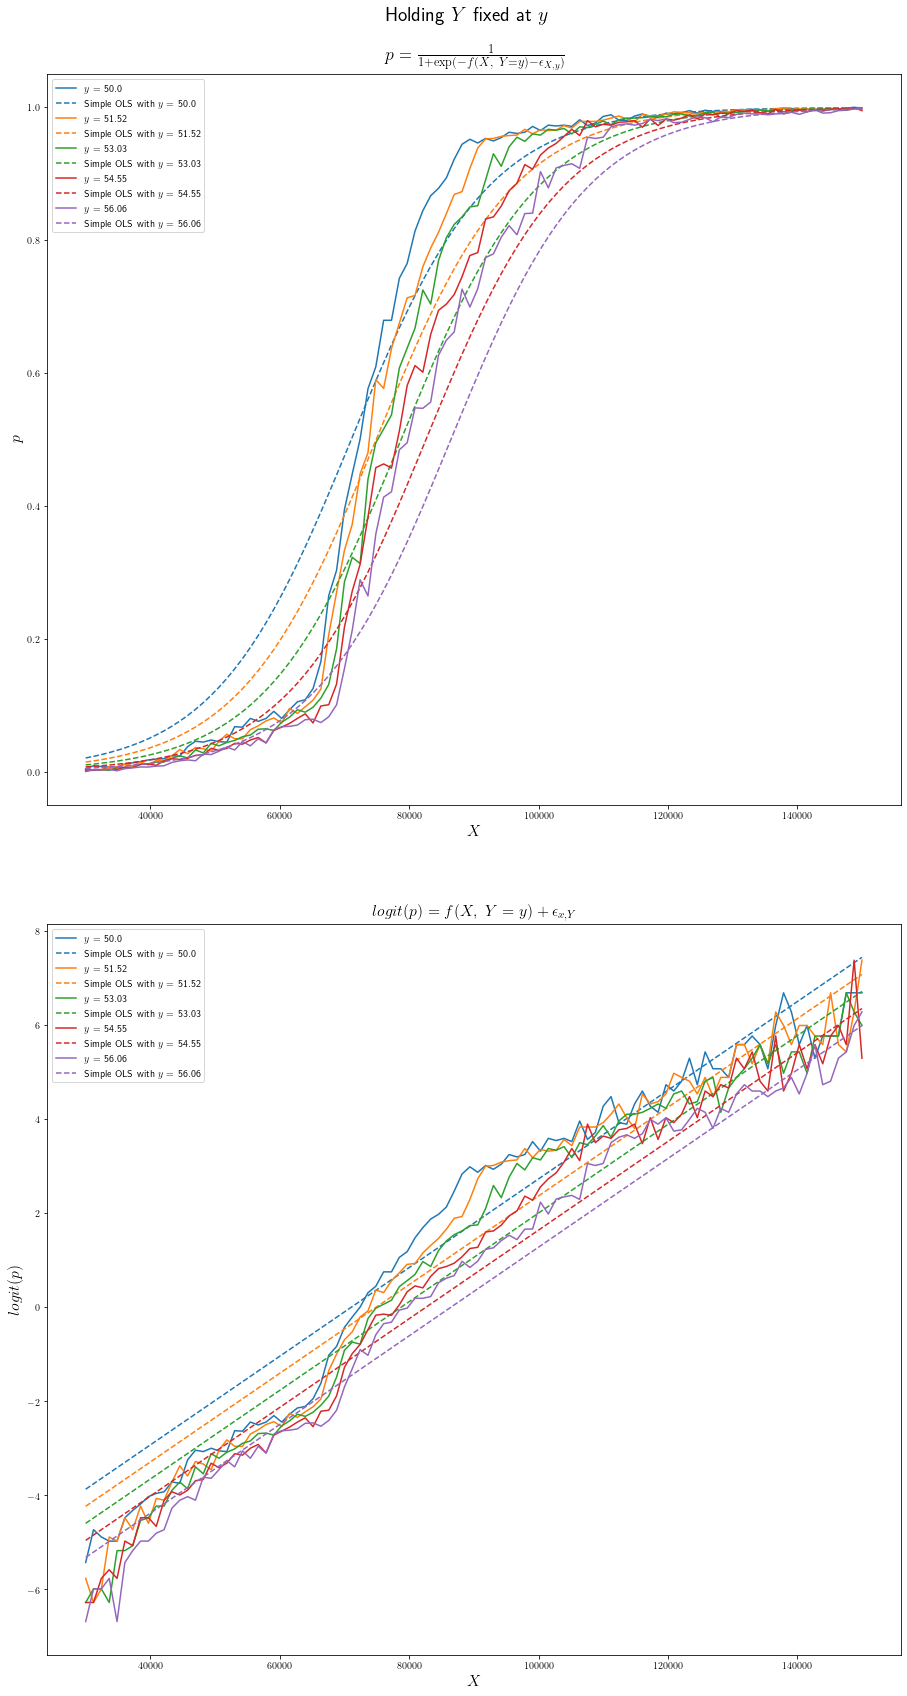

In [16]:
show_fixed_Y_contours(dep_pred, 'Simple OLS')


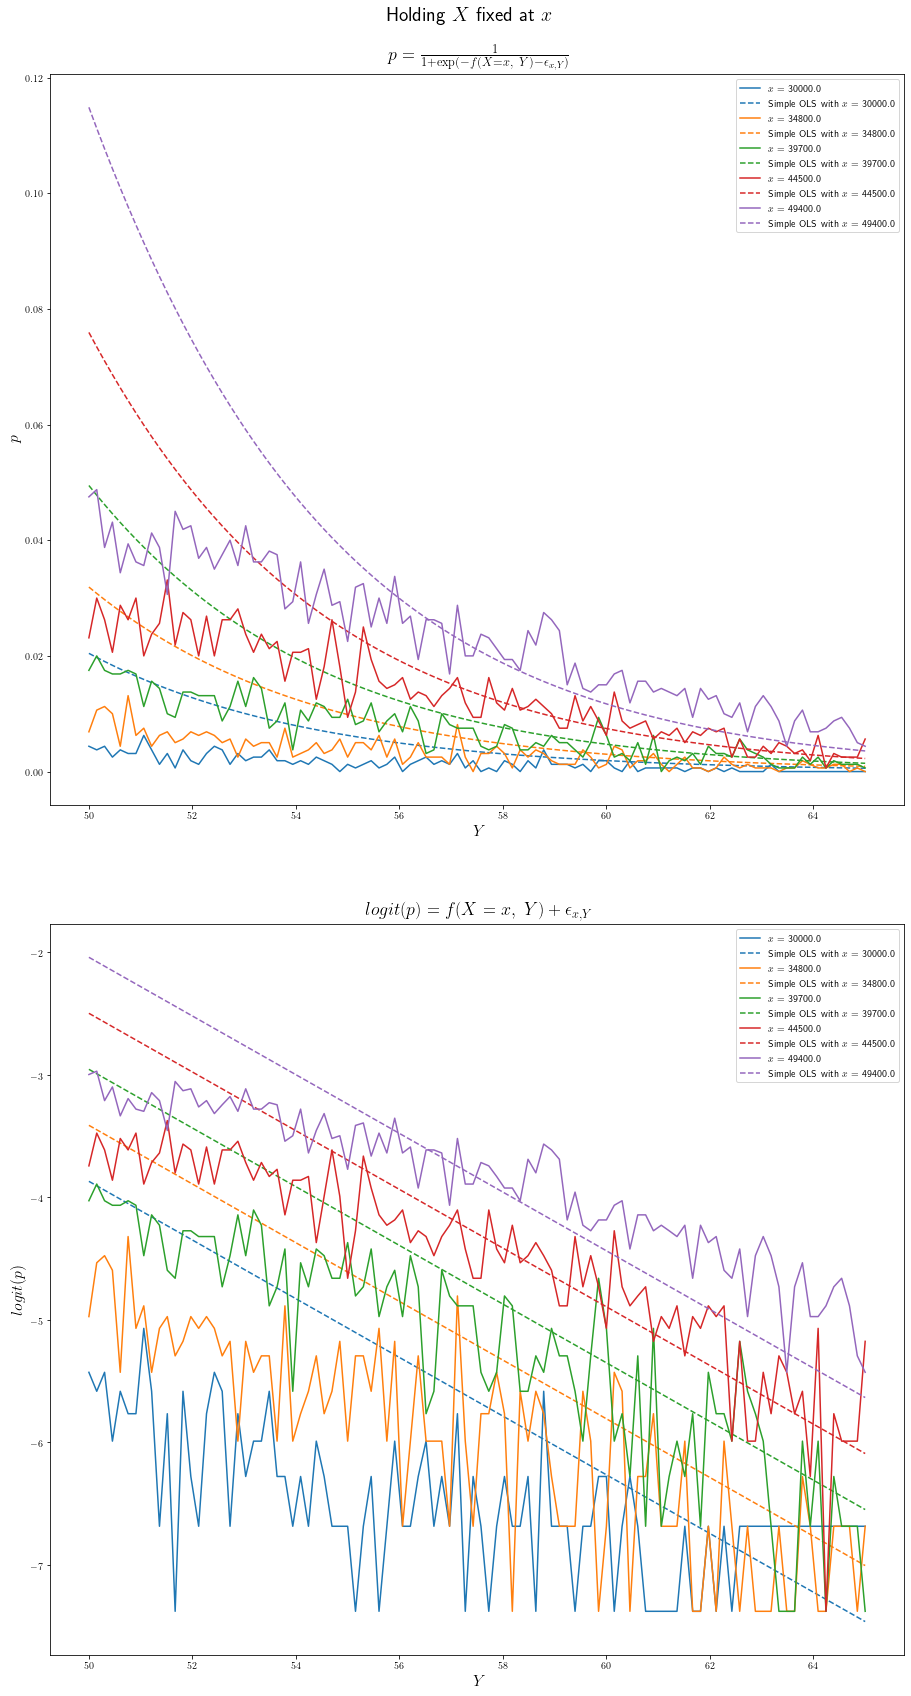

In [17]:
show_fixed_X_contours(dep_pred, 'Simple OLS')

We will consider the more complex OLS model
$$
\hat{f}(X,\ Y) = a_0 + a_1X + a_2Y +a_3X^2 + a_4 XY + a_5 Y^2 + e_{X, Y}.
$$
Inspection of the graphs below shows that the model fits the data relatively well. The simple quadratic curves suggest that we do not have an over-fitting problem.

In [18]:
# Fit complex OLS regression
reg1 = LinearRegression().fit(indep_train, dep_train['log_odds'])

# Record error on validation set
results.loc['Complex_OLS', ['MSE_p', 'MSE_log_odds']] = penalty(dep_val, reg1.predict(indep_val))

# Predict values in training set
dep_pred = reg1.predict(indep_train)


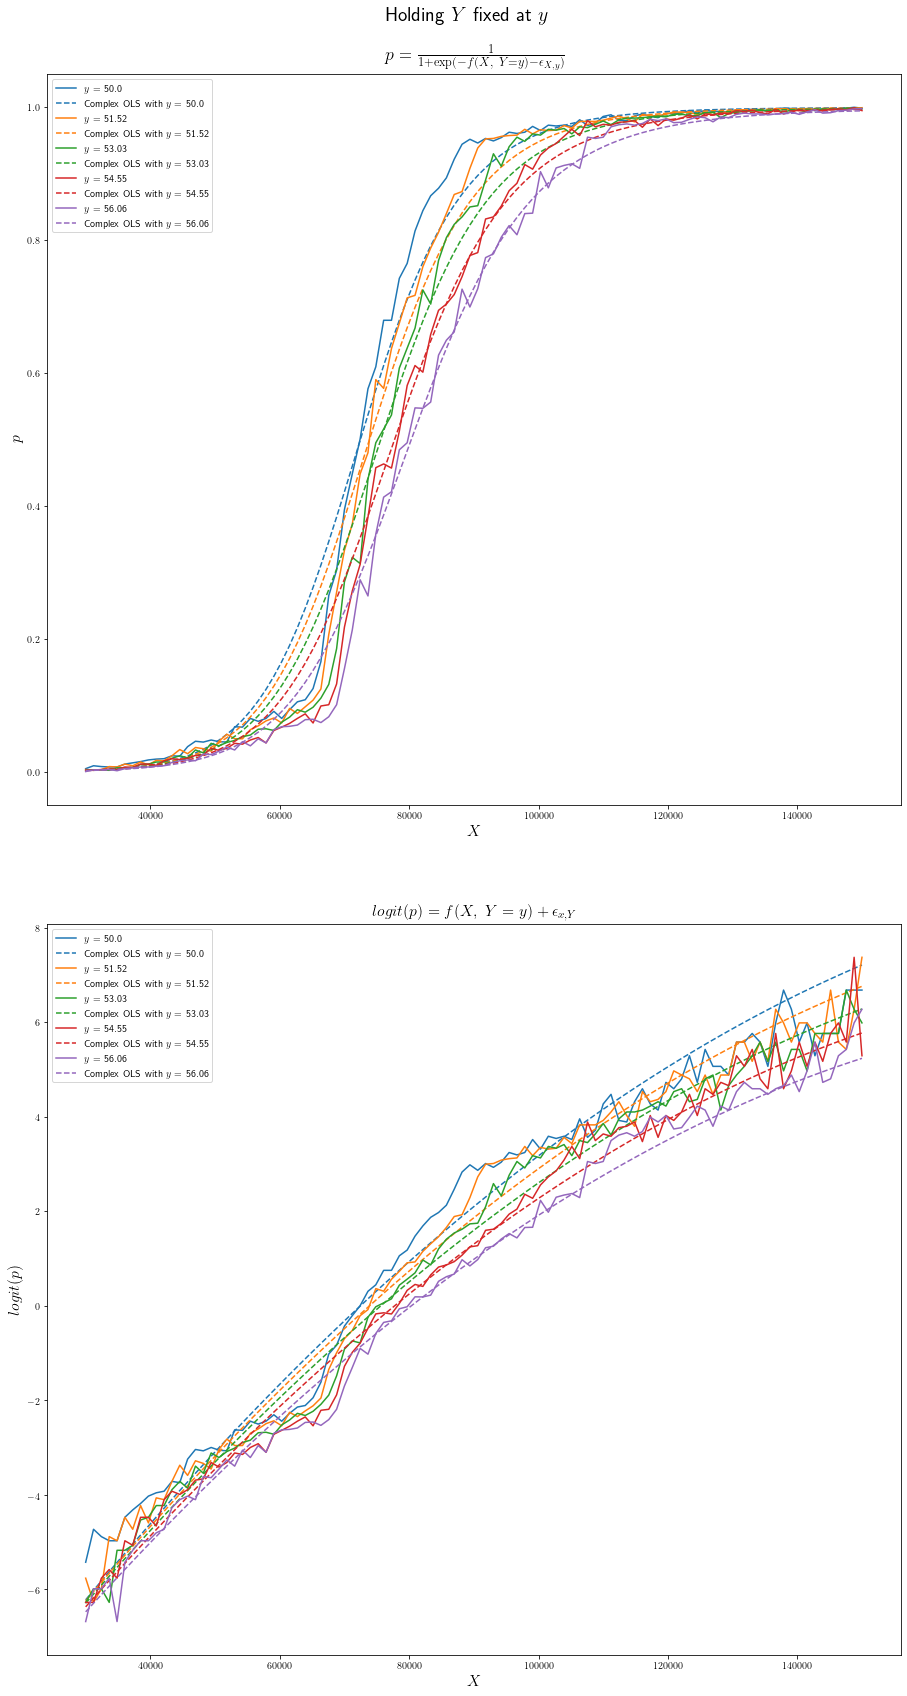

In [19]:
show_fixed_Y_contours(dep_pred, 'Complex OLS')


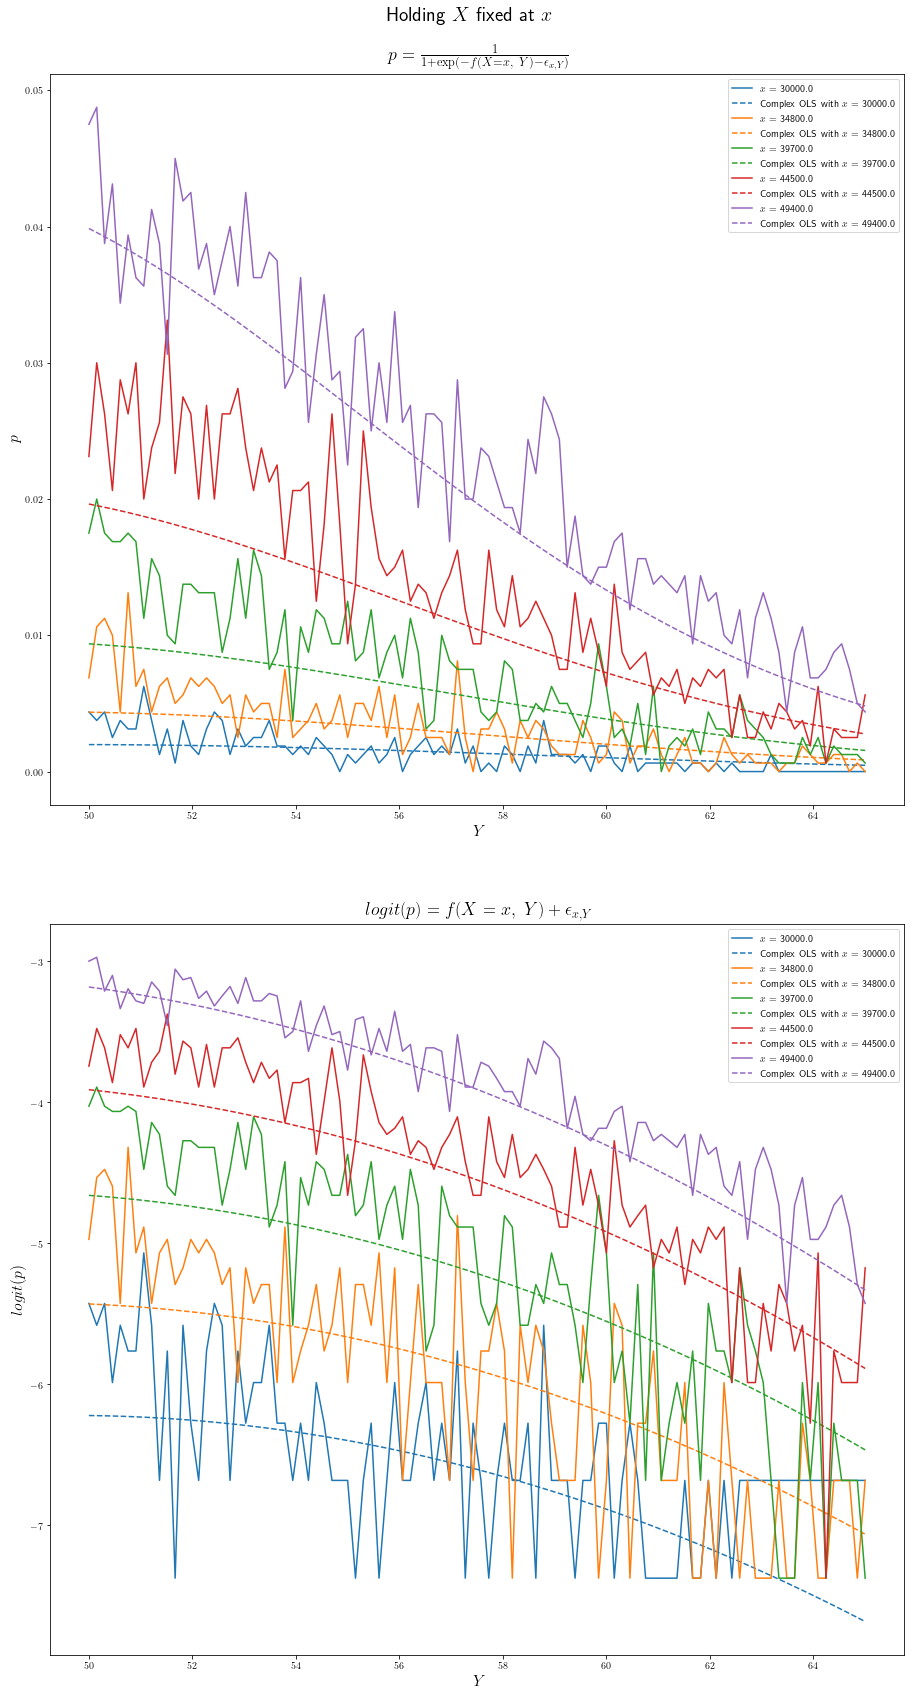

In [20]:
show_fixed_X_contours(dep_pred, 'Complex OLS')
    

To verify that the introduction of these second-order variables is statistically justified, we used an $F$-test. In particular, our test statistic was
$$
\frac{(R_1^2 - R_0^2)/(k_1 - k_0)}{(1 - R_1^2)/(n - k_1 - 1)}\sim{\mathcal{F}(k_1 - k_0, n - k_1 -1)},
$$
where $R_0^2$ is the $R^2$-value of the strictly linear model, $R_1^2$ is the $R^2$-value of the regression with the second-order variables,  $k_0 = 3$, $k_1 = 6$, and $n = 10,000$. This produced a statistically significant $p$-value which indicates that there is sufficent justification for their inclusion. We tried models with only some of the second-order variables and found that their inclusion was statistically justified but they did not have as much predictive power as full set of second-order variables.

In [21]:
# Record R^2-values for F-test
R_sqr_0 = reg0.score(indep_train[:, 0:2], dep_train['log_odds'])
R_sqr_1 = reg1.score(indep_train, dep_train['log_odds'])

# Degrees of freemdom
d_1 = 1 + len(indep_train[0, :]) - (len(indep_val[0, 0:2]) + 1)
d_2 = len(indep_train) - (len(indep_train[0, :]) + 1)

# Test statistic
TS = ((R_sqr_1 - R_sqr_0)/d_1)/((1 - R_sqr_1)/d_2)

# p-value; note the quarky order of the degrees of freedom within scipy.stats
p_val = 1 - stats.f.cdf(TS, d_2, d_1)

p_val

2.0236369365767004e-06

## XGBoost
The next model we considered was XGBoost. We used the explanatory variables
$$
X,\quad Y,\quad X^2,\quad XY, \quad\text{and}\quad Y^2.
$$
As seen above, there is sufficient justification to use the second-order terms in an OLS regression. Therefore, it follows that there is justification to use them in a more flexible model like XGBoost.

The XGBoost regression produced a very impressive fit. However, inspection of the contour graphs indicates over-fitting. We increased cv from five to ten to try and select better hyperparameters, which moved them in the expected direction but did not completely resolve the issue. We also considered $L1$ and $L2$ regularization (reg_alpha and reg_lambda, respectively), but grid search selected the default hyperparameters reg_alpha = 0 and reg_lambda = 1. We did not consider regularization hyperparameters of reg_alpha and reg_lambda below their default values.

In [22]:
# Instantiate model
xgboost = xgb.XGBRegressor()

# Hyperparameters to consider
xgb_params = {'learning_rate': [0.10, 0.15, 0.20], 'max_depth': [6, 8, 10], 'n_estimators': [200, 230, 260]}

# Instantiate grid search
grid_search = GridSearchCV(param_grid = xgb_params, estimator = xgboost, scoring = 'neg_mean_squared_error', cv = 10, 
                           verbose = 0)

# Fit grid_search to the data
grid_search.fit(indep_train, dep_train['log_odds'])

# Hyperparameters are in the centers their ranges (we considered more values but removed them to speed up the calculation)
grid_search.best_params_

{'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 230}

In [23]:
# Instantiate model with hyperparameters
xgboost = xgb.XGBRegressor(learning_rate = grid_search.best_params_['learning_rate'],
                           max_depth = grid_search.best_params_['max_depth'], 
                           n_estimators = grid_search.best_params_['n_estimators'])       
          
# Fit model
xgboost.fit(indep_train, dep_train['log_odds'])

# Record results
results.loc['XGB', ['MSE_p', 'MSE_log_odds']] = penalty(dep_val, xgboost.predict(indep_val))

# Predict values in training set
dep_pred = xgboost.predict(indep_train)

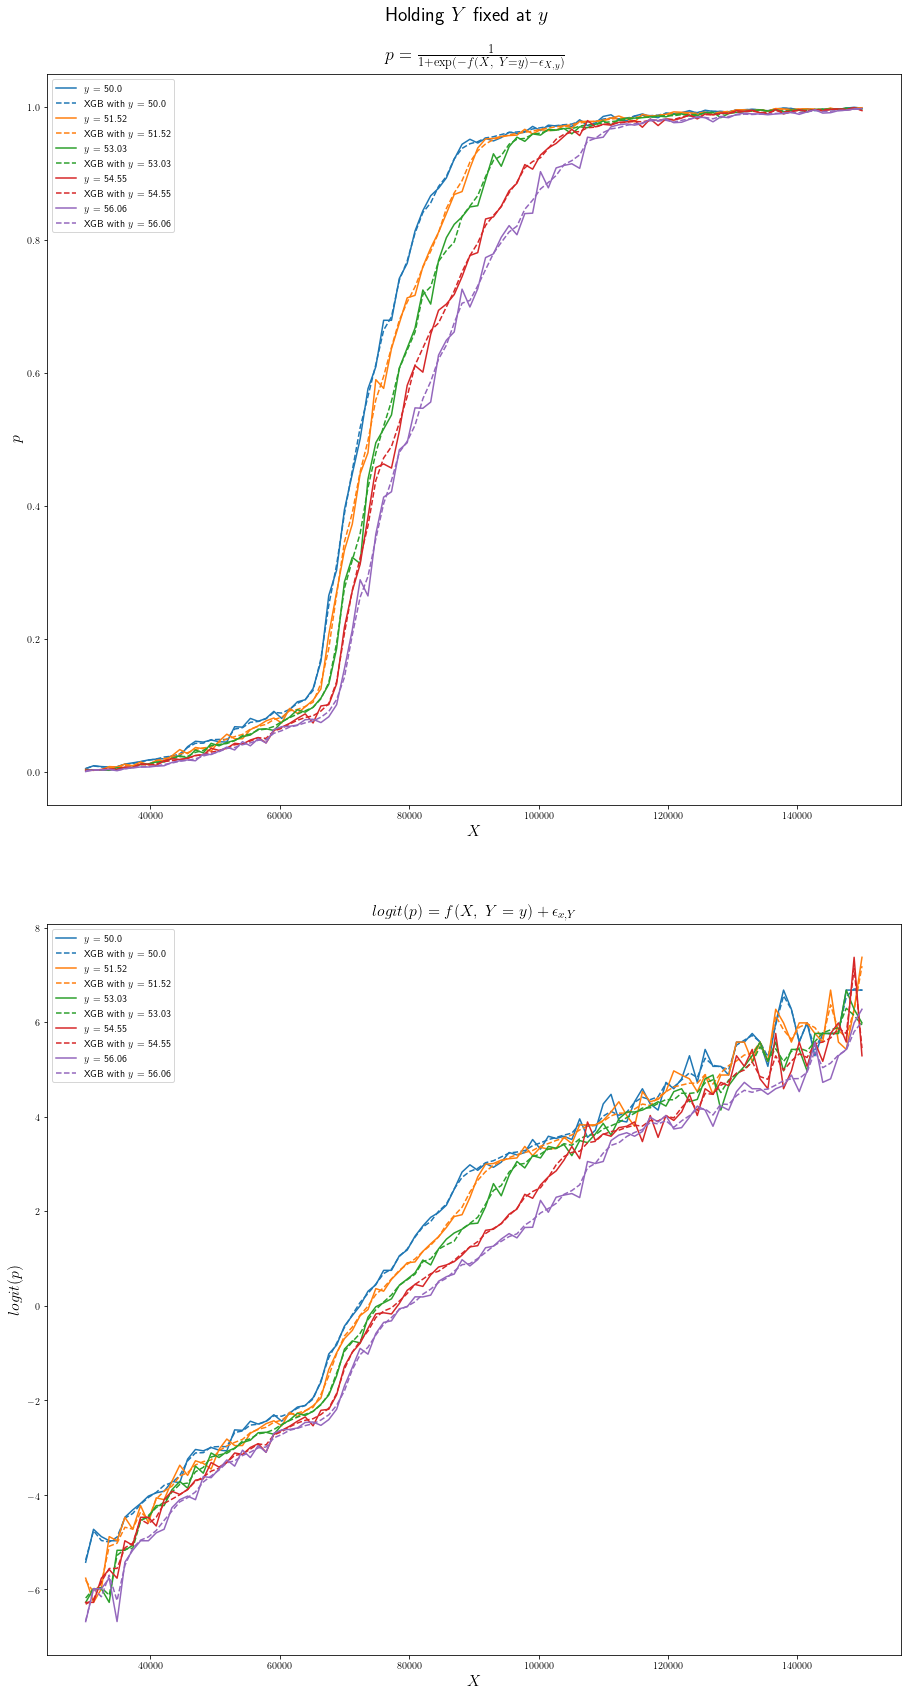

In [24]:
show_fixed_Y_contours(dep_pred, 'XGB')

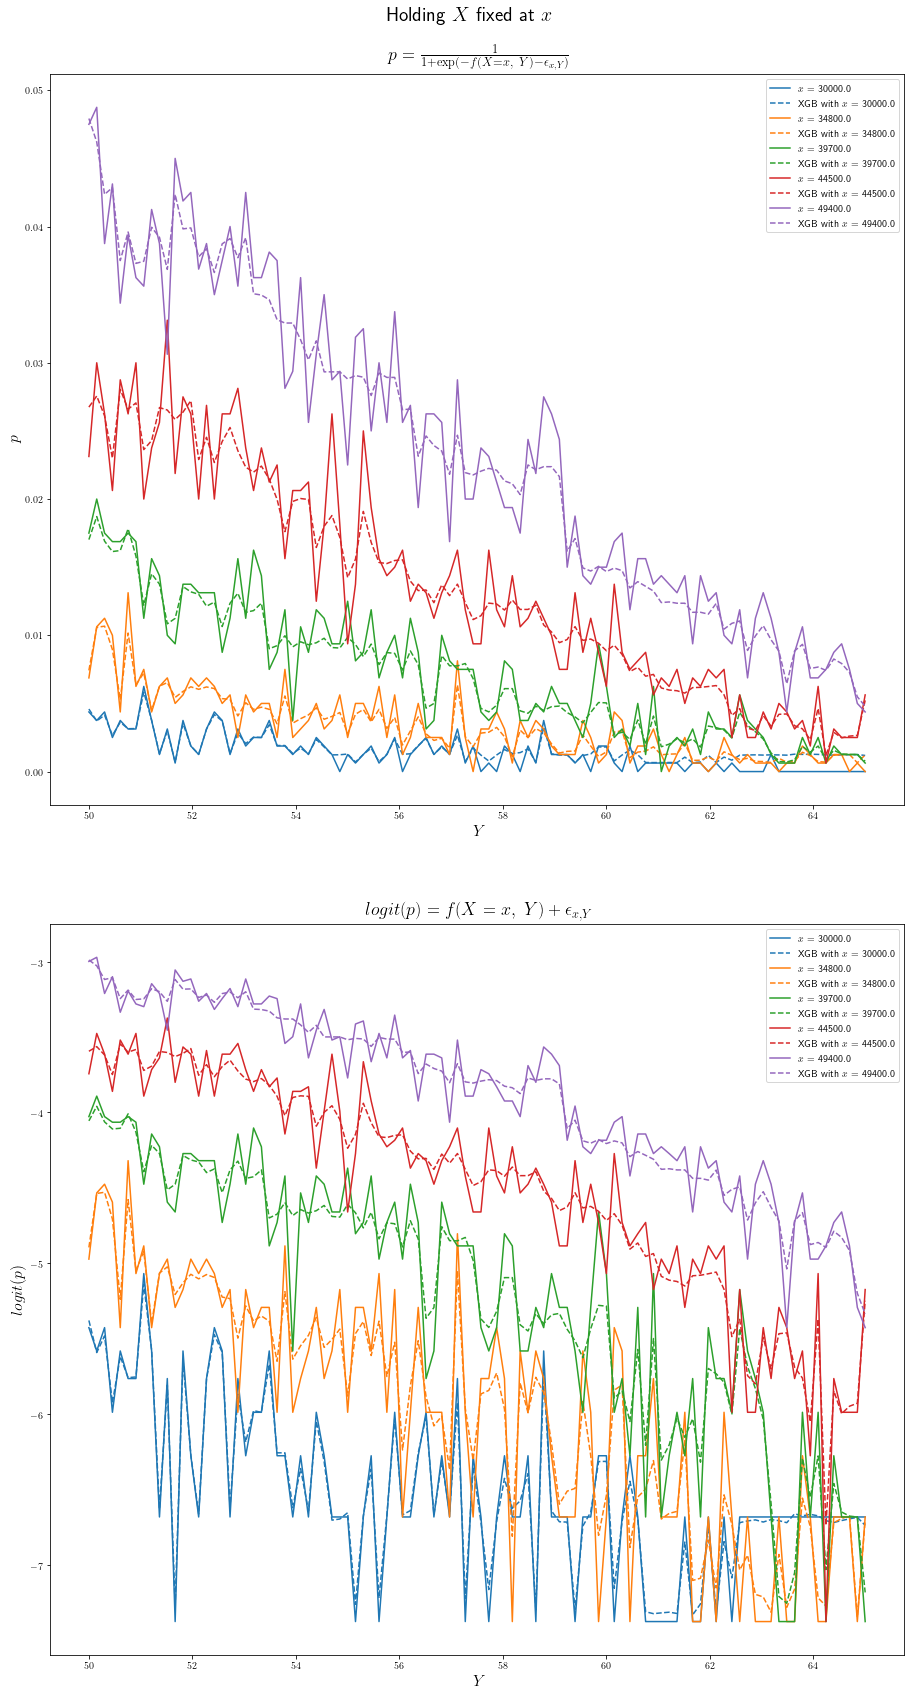

In [25]:
show_fixed_X_contours(dep_pred, 'XGB')

## Neural network
The last model we considered was a neural network. The fit for this model was also impressive. Unlike XGBoost, the smooth contours obtained from the predicted values suggest that we did not have an over-fitting problem. Other than the activation function which grid search always selected to be relu, the grid search algorithm was unstable. We considered three values for the hidden layer and L2 regularization and did not optimize further.

In [26]:
# Instantiate model
nn = MLPRegressor()

# Hyperparameters to consider
nn_params = {'activation':['relu'], 'hidden_layer_sizes': [75, 100, 125], 'alpha': [10**-5, 10**-3, 10**-1]}

# Instantiate grid search
grid_search = GridSearchCV(param_grid = nn_params, estimator = nn, scoring = 'neg_mean_squared_error', 
                           cv = 5, verbose = 0)

# Fit grid_search to the data
grid_search.fit(indep_train, dep_train['log_odds'])

# What are the hyperparameters? 
grid_search.best_params_

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 100}

In [27]:
# Reinstantiate model with new hyperparameters
nn = MLPRegressor(activation = grid_search.best_params_['activation'], 
                        hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes'], 
                        alpha = grid_search.best_params_['alpha'])       
          
# Fit model
nn.fit(indep_train, dep_train['log_odds'])

# Record results on validation set
results.loc['Neural_Net', ['MSE_p', 'MSE_log_odds']] = penalty(dep_val, nn.predict(indep_val))

# Predict log-odds
dep_pred = nn.predict(indep_train)

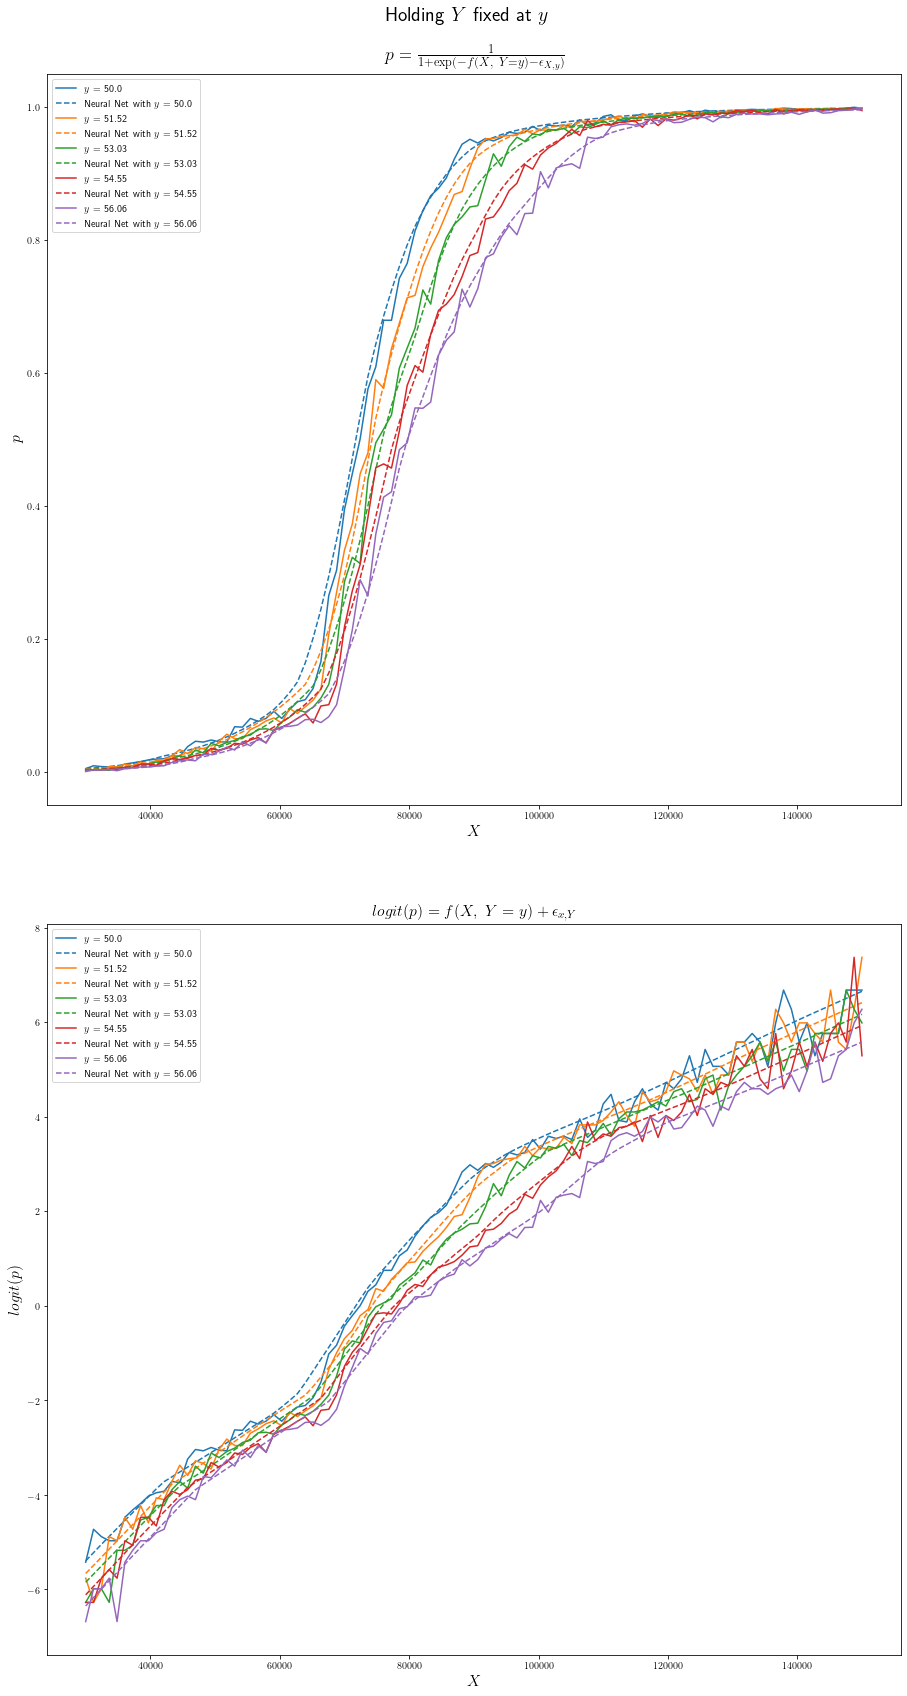

In [28]:
show_fixed_Y_contours(dep_pred, 'Neural Net')

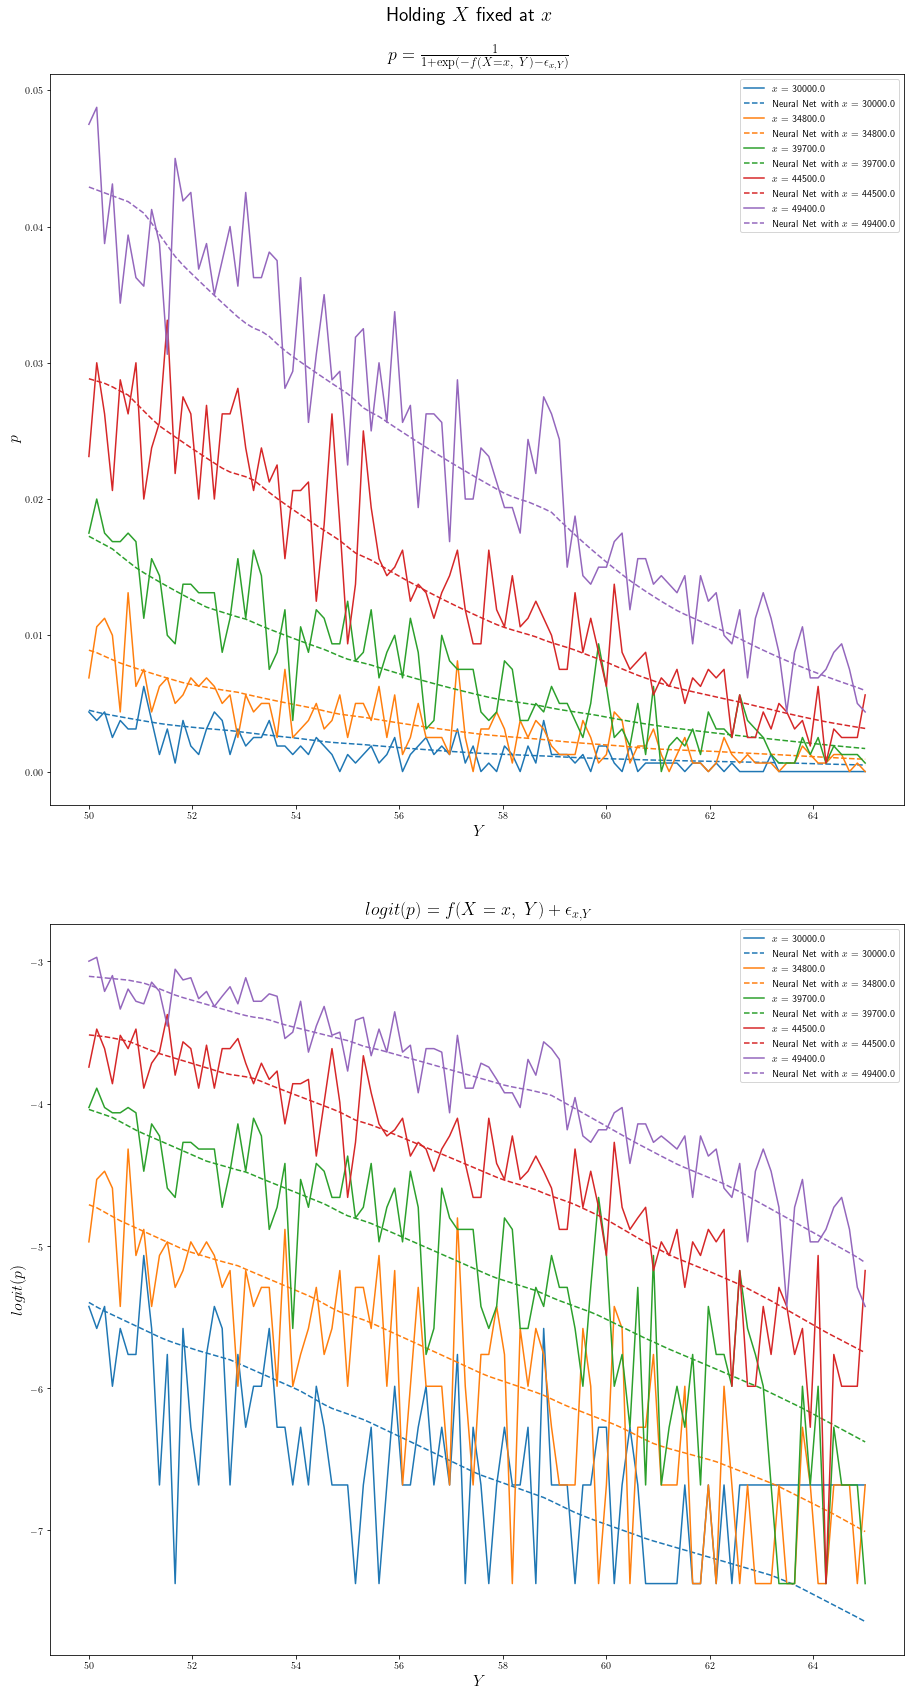

In [29]:
show_fixed_X_contours(dep_pred, 'Neural Net')

## What is the best model?
The model performances on our validation set are shown below. XGBoost, by far, produced the lowest mean square errors. The neural net came in second. Despite the neural net having much larger mean squared errors than those of XGBoost, the results are not conclusive because XGBoost over-fit the data within the training set. However, XGBoost's results are sufficiently strong that we will move forward with it as our preferred model. (Edit: We reran the code and grid search produced better hyperparmeters for the neural network and the result was lower mean square errors so which model is better is even less clear.)

In [30]:
results.iloc[0:4, :]

MSE_p MSE_log_odds
Simple_OLS    0.00606907     0.555059
Complex_OLS   0.00149312     0.160243
XGB           0.00020438    0.0631669
Neural_Net   0.000285547    0.0619806

# Model performance out-of-sample
The last step is to see how we would expect our preferred model to perform on unseen data. This is different than how we used our validation set. When a model performed poorly on the validation set we reconstructed it. We will merge our training set with the validation set to estimate the parameters of our XGBoost model.

Since we have 15,000 observations, we will use 15-fold cross-validation. We are pleased that the hyperparameters selected by grid search are more conservative than those chosen by grid search when using only the training data. We will skip re-standardization because it is not necessary for XGBoost.

In [31]:
# Merge training and validation sets for final calculation
indep_full = np.concatenate([indep_train, indep_val], axis = 0)
dep_full = np.concatenate([dep_train, dep_val], axis = 0)

# Instantiate model
xgboost_full = xgb.XGBRegressor()

# Hyperparameter ranges
xgb_params = {'learning_rate': [0.01, 0.05, 0.06], 'max_depth': [4, 6, 8], 'n_estimators': [110, 140, 170],
             'reg_lambda':[1.2, 1.3, 1.4]}

# Run grid search
grid_search = GridSearchCV(param_grid = xgb_params, estimator = xgboost_full, scoring = 'neg_mean_squared_error', 
                           cv = 15, verbose = 0)

# Fit grid_search to the data
grid_search.fit(indep_full, dep_full[:, 1])

grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 140, 'reg_lambda': 1.3}

In [32]:
# Reinitialize XGBoost
xgboost_full = xgb.XGBRegressor(learning_rate = grid_search.best_params_['learning_rate'],
                           max_depth = grid_search.best_params_['max_depth'], 
                           n_estimators = grid_search.best_params_['n_estimators'],
                                reg_lambda = grid_search.best_params_['reg_lambda'])       

# Fit model
xgboost_full.fit(indep_full, dep_full[:, 1])

# Predict the independent variable
dep_pred = xgboost_full.predict(indep_out)

In [33]:
# Create data frame
out_of_sample = pd.DataFrame(np.concatenate([indep_out, dep_out], axis = 1), 
                             columns = ['X', 'Y', 'X^2', 'XY', 'Y^2', 'p', 'log_odds'])
out_of_sample['p_hat'] = prob(dep_pred)
out_of_sample['log_odds_hat'] = dep_pred

# Sort values
out_of_sample.sort_values(['X', 'Y'], inplace = True, ignore_index = True)

out_of_sample.head()

X         Y       X^2        XY       Y^2       p  log_odds  \
0 -1.646694 -1.670947 -1.294571 -1.726694 -1.601866  0.0025 -5.988961   
1 -1.646694 -1.610439 -1.294571 -1.722525 -1.548940  0.0025 -5.988961   
2 -1.646694 -1.606566 -1.294571 -1.722258 -1.545542  0.0050 -5.293305   
3 -1.646694 -1.580834 -1.294571 -1.720485 -1.522943  0.0025 -5.988961   
4 -1.646694 -1.417721 -1.294571 -1.709247 -1.378514  0.0050 -5.293305   

      p_hat  log_odds_hat  
0  0.003917     -5.538547  
1  0.004507     -5.397625  
2  0.004507     -5.397625  
3  0.004391     -5.423865  
4  0.004038     -5.508039

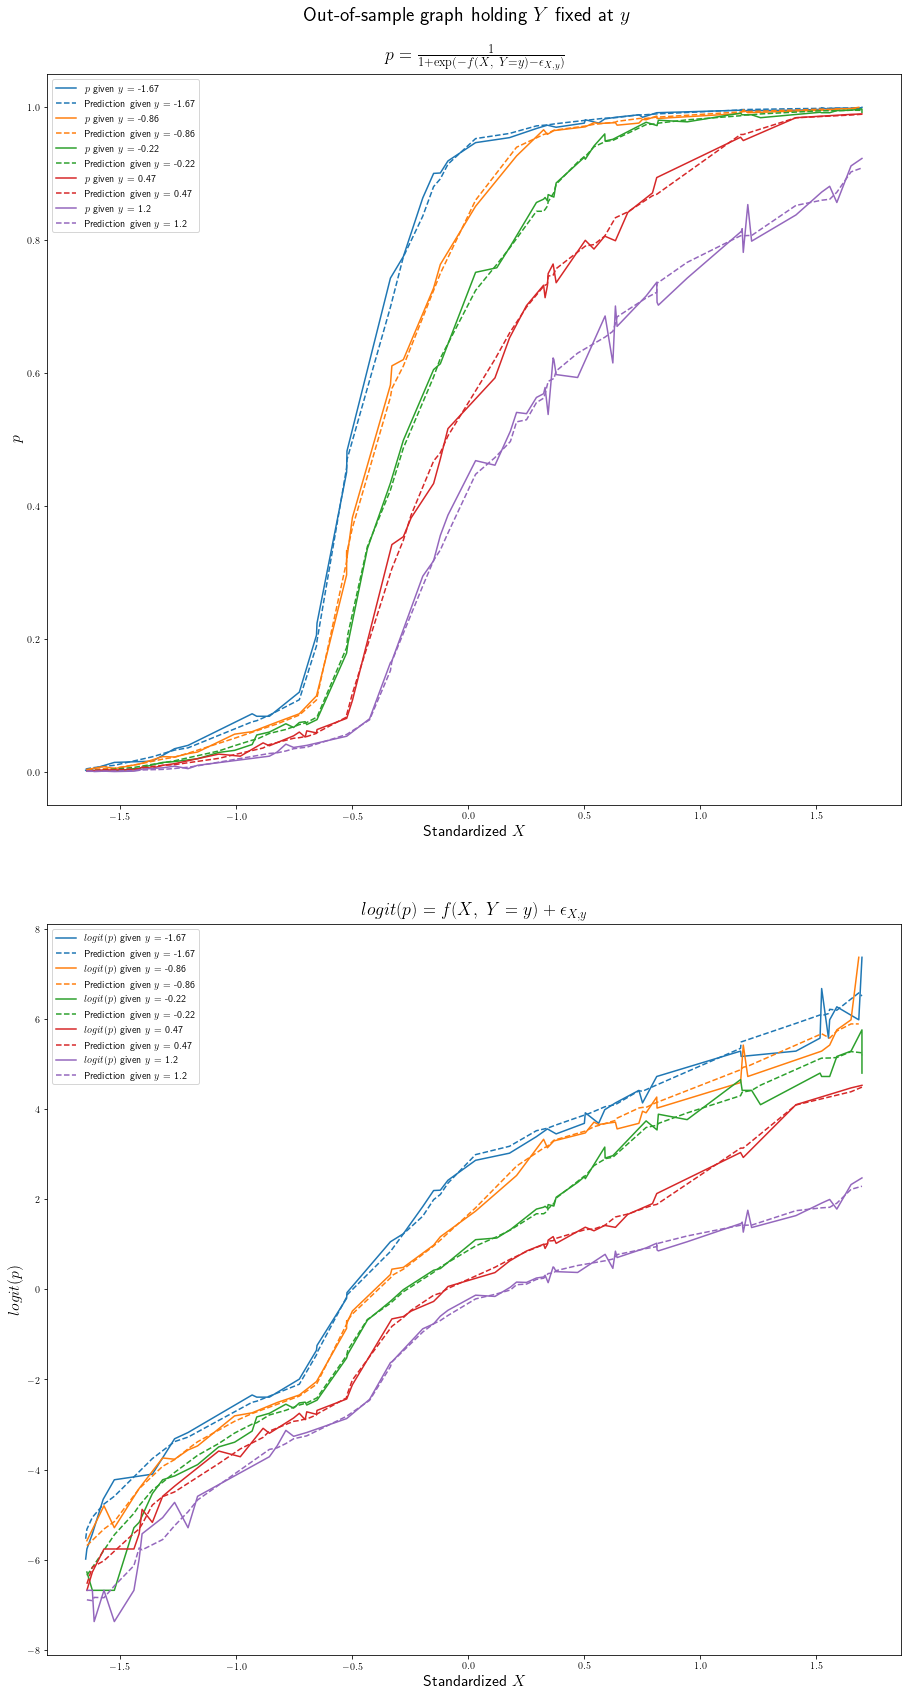

In [37]:
# Choose X- and Y-values for contours
X_vals = np.unique(out_of_sample['X'])[0:100:20]
Y_vals = np.unique(out_of_sample['Y'])[0:100:20]
    
# Initialize i to 0
i = 0

fig, ax = plt.subplots(2, 1, figsize = (15, 25))
fig.suptitle(r'Out-of-sample graph holding $Y$ fixed at $y$', fontsize = 20)
plt.tight_layout(pad = 10)

for Y in Y_vals:
    ax[0].set_title(r'$p = \frac{1}{1 + \exp(-f(X,\ Y = y) - \epsilon_{X, y})}$', fontsize = 18)
    ax[0].plot(out_of_sample.loc[out_of_sample['Y'] == Y, 'X'], out_of_sample.loc[out_of_sample['Y'] == Y, 'p'], color = colors[i], 
               label = r'$p$ given $y$ = {}'.format(round(Y, 2)))
    ax[0].plot(out_of_sample.loc[out_of_sample['Y'] == Y, 'X'], out_of_sample.loc[out_of_sample['Y'] == Y, 'p_hat'], color = colors[i], 
               linestyle = 'dashed', label = r'Prediction given $y$ = {}'.format(round(Y, 2)))
    ax[0].set_xlabel(r'Standardized $X$', fontsize = 16) 
    ax[0].set_ylabel(r'$p$', fontsize = 16) 
    ax[0].legend()
    
    ax[1].set_title(r'$logit(p) = f(X,\ Y = y) + \epsilon_{X, y}$', fontsize = 18)
    ax[1].plot(out_of_sample.loc[out_of_sample['Y'] == Y, 'X'], out_of_sample.loc[out_of_sample['Y'] == Y, 'log_odds'], color = colors[i], 
               label = r'$logit(p)$ given $y$ = {}'.format(round(Y, 2)))
    ax[1].plot(out_of_sample.loc[out_of_sample['Y'] == Y, 'X'], out_of_sample.loc[out_of_sample['Y'] == Y, 'log_odds_hat'], color = colors[i], 
               linestyle = 'dashed', label = r'Prediction given  $y$ = {}'.format(round(Y, 2)))
    ax[1].set_xlabel(r'Standardized $X$', fontsize = 16)  
    ax[1].set_ylabel(r'$logit(p)$', fontsize = 16) 
    ax[1].legend()
    i += 1
    
plt.show()

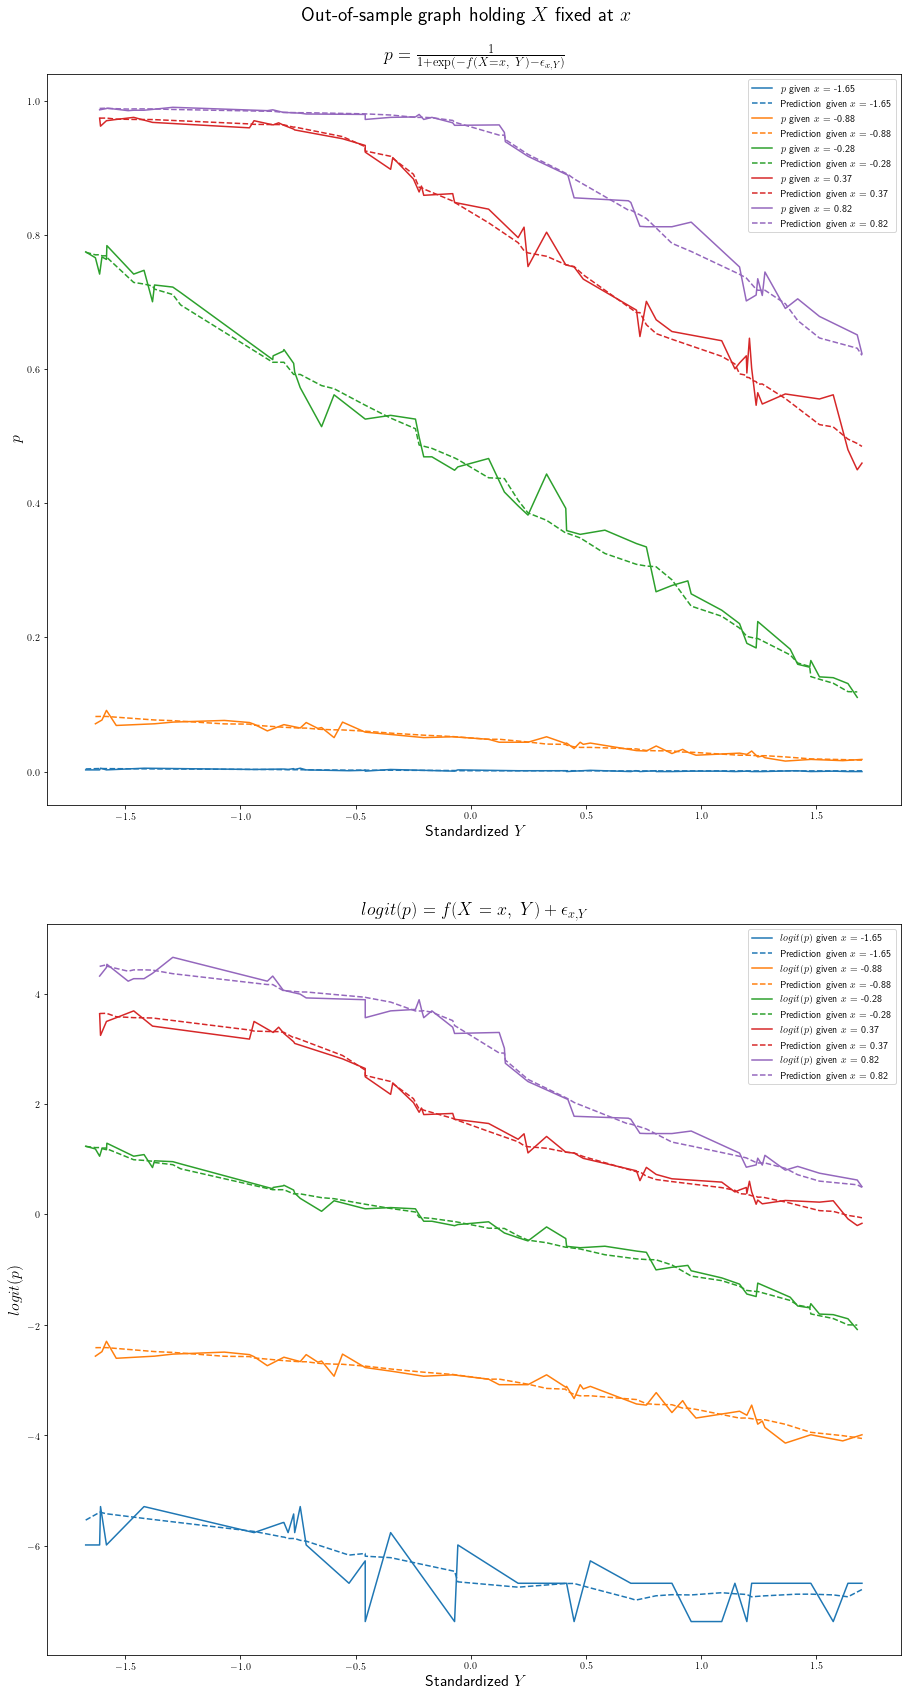

In [38]:
# Reinitialize i to 0
i = 0

fig, ax = plt.subplots(2, 1, figsize = (15, 25))
fig.suptitle(r'Out-of-sample graph holding $X$ fixed at $x$', fontsize = 20)
plt.tight_layout(pad = 10)

for X in X_vals:
    ax[0].set_title(r'$p = \frac{1}{1 + \exp(-f(X = x,\ Y ) - \epsilon_{x, Y})}$', fontsize = 18)
    ax[0].plot(out_of_sample.loc[out_of_sample['X'] == X, 'Y'], out_of_sample.loc[out_of_sample['X'] == X, 'p'], color = colors[i], 
               label = r'$p$ given $x$ = {}'.format(round(X, 2)))
    ax[0].plot(out_of_sample.loc[out_of_sample['X'] == X, 'Y'], out_of_sample.loc[out_of_sample['X'] == X, 'p_hat'], color = colors[i], 
               linestyle = 'dashed', label = r'Prediction given $x$ = {}'.format(round(X, 2)))
    ax[0].set_xlabel(r'Standardized $Y$', fontsize = 16) 
    ax[0].set_ylabel(r'$p$', fontsize = 16) 
    ax[0].legend()
    
    ax[1].set_title(r'$logit(p) = f(X = x,\ Y) + \epsilon_{x, Y}$', fontsize = 18)
    ax[1].plot(out_of_sample.loc[out_of_sample['X'] == X, 'Y'], out_of_sample.loc[out_of_sample['X'] == X, 'log_odds'], color = colors[i], 
               label = r'$logit(p)$ given $x$ = {}'.format(round(X, 2)))
    ax[1].plot(out_of_sample.loc[out_of_sample['X'] == X, 'Y'], out_of_sample.loc[out_of_sample['X'] == X, 'log_odds_hat'], color = colors[i], 
               linestyle = 'dashed', label = r'Prediction given $x$ = {}'.format(round(X, 2)))
    ax[1].set_xlabel(r'Standardized $Y$', fontsize = 16) 
    ax[1].set_ylabel(r'$logit(p)$', fontsize = 16) 
    ax[1].legend()
    i += 1
    
plt.show()

In [39]:
results.loc['XGB_out', :] = penalty(dep_out, dep_pred)
results

MSE_p MSE_log_odds
Simple_OLS    0.00606907     0.555059
Complex_OLS   0.00149312     0.160243
XGB           0.00020438    0.0631669
Neural_Net   0.000285547    0.0619806
XGB_out      0.000175715    0.0526753

# Conclusion

Grid search selected a more conservative set of hyperparameters when fit using both the training and validation set, which was encouraging considering the XGBoost regression seemed to be over-fitting when it just used the training data. Our out-of-sample results produced lower mean square errors than even the XGBoost model on the validation set. In the end, despite the noise due to a small value of $N$, we were able to construct a model which predicted $p$ accurately.